# Section 3. Metrics

## Inception Score (IS)
​
[original paper](https://arxiv.org/abs/1606.03498)
​

**Aim**: see how variate samples are

### Idea
Let's see how much classes our generative model is able to generate

![image](https://miro.medium.com/max/2976/1*X29oOi1Tzch2j6MuG9XS1Q.png)
![image](https://miro.medium.com/max/2812/1*t8lE_W4UKQ8jKgzxCAbHTA.png)

### How it works
We compare each samples classes with averaged (marginal) one. If each sample's distribution differs from common (marginal) one, then it differs from others.

![image](https://miro.medium.com/max/3472/1*hPEJY3MkOZyKFA6yEqzuyg.png)

Here KL divergence is used to calculate the distance



## Frechet Inception Distance (FID)

**Idea**: compare distributions of real and generated samples

**Algorithm**:
1. Get samples embeddings from intermediate layers of neural network pre-trained on some external dataset
2. Approximate embeddings of real and generated samples by gaussians $\mathcal{N}(\mu_1, \Sigma_1)$ and $\mathcal{N}(\mu_2, \Sigma_2)$ respectively
3. Calclulate Frecher Distance = $\|\mu_1 – \mu_2\|^2 + Tr(\Sigma_1 + \Sigma_2 - 2 * \text{sqrt}(\Sigma_1*\Sigma_2))$. The smaller the better

## Metrics summary

![](https://miro.medium.com/max/875/0*GHvXKp6DQPAHGdqH)



### Comparison

|                            Metric |                                 IS                                 | FID                                                            |
|----------------------------------:|:------------------------------------------------------------------:|----------------------------------------------------------------|
| **Aim**                               | show *how variate* generated images are                            | show *how close* generated images to real ones are             |
| Which distributions are compared? | Discrete predicted class distributions (marginal vs. sample's one) | Two continuous gaussian distributions (real vs. generated one) |
| Which data is used?               | Generated only                                                     | Generated and real                                             |
| Which distance is used?           | KL                                                                 | Frechet distance                                               |

### Task
Implement FID and IS distances

The code is based on https://github.com/lzhbrian/metrics

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3

from scipy.stats import entropy
import scipy.misc
from scipy import linalg
import numpy as np
from tqdm import tqdm
from glob import glob
import pathlib
import os
import sys
import random


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    if isinstance(mu1, int): mu1 = mu1*np.ones_like(mu2)
    if isinstance(sigma1, int): sigma1 = sigma1*np.ones_like(sigma2)
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths %s, %s' % (mu1.shape, mu2.shape)
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions %s, %s' % (sigma1.shape, sigma2.shape)
    
    # Implement FID distance here
    # YOUR CODE HERE
    diff = mu1 - mu2
    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    tr_covmean = np.trace(covmean)

    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return fid


In [2]:
class ScoreModel:
    def __init__(self, mode, cuda=True,
                 stats_file='', mu1=0, sigma1=0):
        """
        Computes the inception score of the generated images
            cuda -- whether or not to run on GPU
            mode -- image passed in inceptionV3 is normalized by mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                and in range of [-1, 1]
                1: image passed in is normalized by mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                2: image passed in is normalized by mean=[0.500, 0.500, 0.500], std=[0.500, 0.500, 0.500]
        """

        self.mu1, self.sigma1 = mu1, sigma1

        # Set up dtype
        if cuda:
            self.dtype = torch.cuda.FloatTensor
        else:
            if torch.cuda.is_available():
                print("WARNING: You have a CUDA device, so you should probably set cuda=True")
            self.dtype = torch.FloatTensor

        # setup image normalization mode
        self.mode = mode
        if self.mode == 1:
            transform_input = True
        elif self.mode == 2:
            transform_input = False
        else:
            raise Exception("ERR: unknown input img type, pls specify norm method!")
        self.inception_model = inception_v3(pretrained=True, transform_input=transform_input).type(self.dtype)
        self.inception_model.eval()
        # self.up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False).type(self.dtype)

        # remove inception_model.fc to get pool3 output 2048 dim vector
        self.fc = self.inception_model.fc
        self.inception_model.fc = nn.Sequential()

    def __forward(self, x):
        """
        x should be N x 3 x 299 x 299
        and should be in range [-1, 1]
        """
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = self.inception_model(x)
        pool3_ft = x.data.cpu().numpy() # inner activation (of the last layer)

        x = self.fc(x) # output predictions
        preds = F.softmax(x, 1).data.cpu().numpy()
        return pool3_ft, preds

    @staticmethod
    def __calc_is(preds, n_split, return_each_score=False):
        """
        regularly, return (is_mean, is_std)
        if n_split==1 and return_each_score==True:
            return (scores, 0)
            # scores is a list with len(scores) = n_img = preds.shape[0]
        """

        n_img = preds.shape[0]
        
        # Implement Inception Score here
        # Split predictions by chunks of size "n_split" and add IS scores of the chunks to "split_scores" list
        split_scores = []
        # Now compute the mean kl-div
        for k in range(n_split):
            part = preds[k * (n_img // n_split): (k + 1) * (n_img // n_split), :]
            py = np.mean(part, axis=0)
            scores = []
            for i in range(part.shape[0]):
                pyx = part[i, :]
                scores.append(entropy(pyx, py))
            split_scores.append(np.exp(np.mean(scores)))
        return np.mean(split_scores), np.std(split_scores)

    @staticmethod
    def __calc_stats(pool3_ft):
        # pool3_ft is 2048 dimensional inner activation of the InceptionV3 network
        mu = np.mean(pool3_ft, axis=0)
        sigma = np.cov(pool3_ft, rowvar=False)
        return mu, sigma

    def get_score_image_tensor(self, imgs_nchw, mu1=0, sigma1=0,
                               n_split=10, batch_size=32, return_each_score=False):
        """
        param:
            imgs_nchw -- Pytorch Tensor, size=(N,C,H,W), in range of [-1, 1]
            batch_size -- batch size for feeding into Inception v3
            n_splits -- number of splits
        return:
            is_mean, is_std, fid
            mu, sigma of dataset
            regularly, return (is_mean, is_std)
        """

        n_img = imgs_nchw.shape[0]

        assert batch_size > 0
        assert n_img > batch_size

        pool3_ft = np.zeros((n_img, 2048))
        preds = np.zeros((n_img, 1000))
        
        # Fill inner activations "pool3_ft" and output predictions "preds" by the network
        # Hint: use self.__forward()
        # YOUR CODE HERE
        for i in tqdm(range(np.int32(np.ceil(1.0 * n_img / batch_size)))):
            batch_size_i = min((i+1) * batch_size, n_img) - i * batch_size
            batchv = Variable(imgs_nchw[i * batch_size:i * batch_size + batch_size_i, ...].type(self.dtype))
            pool3_ft[i * batch_size:i * batch_size + batch_size_i], preds[i * batch_size:i * batch_size + batch_size_i] = self.__forward(batchv)

        
        mu2, sigma2 = None, None
        # Calculate statistics for inner activations "pool3_ft"
        mu2, sigma2 = self.__calc_stats(pool3_ft)# YOUR CODE HERE
                
        mu1, sigma1 = self.mu1,  self.sigma1

        is_mean, is_std = None, None
        # Calculate IS score
        is_mean, is_std = self.__calc_is(preds, n_split, return_each_score) # YOUR CODE HERE

        fid = -1
        # Calculate FID score
        fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)# YOUR CODE HERE

        return is_mean, is_std, fid, mu2, sigma2
        

    def get_score_dataset(self, dataset, mu1=0, sigma1=0,
                          n_split=10, batch_size=32, return_each_score=False):
        """
        get score from a dataset
        param:
            dataset -- pytorch dataset, img in range of [-1, 1]
            batch_size -- batch size for feeding into Inception v3
            n_splits -- number of splits
        return:
            is_mean, is_std, fid
            mu, sigma of dataset
        """

        n_img = len(dataset)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

        pool3_ft = np.zeros((n_img, 2048))
        preds = np.zeros((n_img, 1000))
        # Fill inner activations "pool3_ft" and output predictions "preds" by the network
        # Hint: use self.__forward()
        # YOUR CODE HERE
        for i, batch in tqdm(enumerate(dataloader, 0)):
            batch = batch.type(self.dtype)
            batchv = Variable(batch)
            batch_size_i = batch.size()[0]
            pool3_ft[i * batch_size:i * batch_size + batch_size_i], preds[i * batch_size:i * batch_size + batch_size_i] = self.__forward(batchv)

            
        mu2, sigma2 = None, None
        # Calculate statistics for inner activations "pool3_ft"
        mu2, sigma2 = self.__calc_stats(pool3_ft)# YOUR CODE HERE
        
        mu1, sigma1 = self.mu1,  self.sigma1

        is_mean, is_std = None, None
        # Calculate IS score
        is_mean, is_std = self.__calc_is(preds, n_split, return_each_score)# YOUR CODE HERE
        
        fid = -1
        # Calculate FID score
        fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)# YOUR CODE HERE

        return is_mean, is_std, fid, mu2, sigma2


In [3]:
# read folder, return torch Tensor in NCHW, normalized
def read_folder(foldername):
    files = []
    for ext in ('*.png', '*.jpg', '*.jpeg', '.bmp'):
        files.extend(glob(os.path.join(foldername, ext)))

    img_list = []
    print('Reading Images from %s ...' % foldername)
    for file in tqdm(files):
        img = scipy.misc.imread(file, mode='RGB')
        img = scipy.misc.imresize(img, (299, 299), interp='bilinear')
        img = np.cast[np.float32]((-128 + img) / 128.)  # 0~255 -> -1~1
        img = np.expand_dims(img, axis=0).transpose(0, 3, 1, 2)  # NHWC -> NCHW
        img_list.append(img)
    random.shuffle(img_list)
    img_list_tensor = torch.Tensor(np.concatenate(img_list, axis=0))
    return img_list_tensor

class IgnoreLabelDataset(torch.utils.data.Dataset):
    def __init__(self, orig, size=1000):
        self.orig = orig
        self.size = size

    def __getitem__(self, index):
        return self.orig[index][0]

    def __len__(self):
        if self.size:
            return self.size
        else:
            return len(self.orig)

import torchvision.datasets as dset
import torchvision.transforms as transforms

cifar = dset.CIFAR10(root='../data/cifar10', download=True,
                     transform=transforms.Compose([
                         transforms.Resize(32),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                     ])
                     )
IgnoreLabelDataset(cifar)

print ("Calculating IS score on CIFAR 10...")
# is_fid_model = ScoreModel(mode=2, cuda=True)
is_fid_model = ScoreModel(mode=2, cuda=False)
is_mean, is_std, fid, _, _ = is_fid_model.get_score_dataset(IgnoreLabelDataset(cifar), n_split=10)

Files already downloaded and verified
Calculating IS score on CIFAR 10...


/home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
32it [02:00,  3.78s/it]
/home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/scipy/linalg/_matfuncs_sqrtm.py:205: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


In [4]:
print(u"Inception score: %.4f\u00B1%.4f"%(is_mean, is_std))
print("FID: %.4f"%fid)

Inception score: 7.8371±0.4692
FID: 486.5226


In [5]:
### GRADED PART, DO NOT CHANGE! 
q1=is_mean

In [6]:
### GRADED PART, DO NOT CHANGE! 
q2=is_std

In [9]:
print([is_mean, is_std])

[7.837093145702037, 0.4691982077079836]


# LPIPS (Learned Perceptual Image Similarity)
$$d_{LPIPS}(x,y)=\Sigma_l\frac{1}{H_lW_l}\Sigma_{i,j}||w_l\cdot(\hat{x}^l_{ij}-\hat{y}^l_{ij})||^2_2$$
where $\hat{x}^l_{ij}$ and $\hat{y}^l_{ij}$ denote the normalized feature vectors at layer $l$ and pixel $(i, j)$, $w_l$ contains weights for each of the features in layer $l$, and $\cdot$ multiplies the feature vectors at each pixel by the specifically learned weights

In [10]:
import torchvision
dataset = torchvision.datasets.FashionMNIST('../data/fashion_mnist', download=True)

In [11]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git

  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-ml5sqyjn
  Running command git clone --filter=blob:none --quiet https://github.com/S-aiueo32/lpips-pytorch.git /tmp/pip-req-build-ml5sqyjn
  Resolved https://github.com/S-aiueo32/lpips-pytorch.git to commit 016e0ae19ceff83450590738948941a7eb9b95b7
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


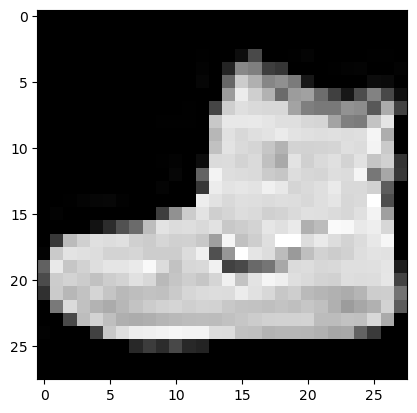

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

original_img_idx = 0
original_img, original_label = dataset[original_img_idx]
plt.imshow(original_img, cmap='gray')

### Task
Find closest image to the above one

In [13]:
from lpips_pytorch import LPIPS, lpips
# from tqdm.notebook import tqdm
from tqdm import tqdm

# define as a criterion module (recommended)
criterion = LPIPS(
    net_type='alex',  # choose a network type from ['alex', 'squeeze', 'vgg']
    version='0.1'  # Currently, v0.1 is supported
)

def img2tensor(img):
    return torch.from_numpy(np.array(img.resize((512,512))))

np.random.seed(10)
img_indices = np.random.choice(np.arange(len(dataset)), 1000) # random images to be compared
img_indices = [idx for idx in img_indices if idx != original_img_idx]

distances, labels = [], []

# calculate LPIPS distances
for idx in tqdm(img_indices):
    # distance = ??? # YOUR CODE HERE
    distance = criterion(img2tensor(original_img), img2tensor(dataset[idx][0]))
    distances.append(distance)
    labels.append(dataset[idx][1])

/home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1000/1000 [01:55<00:00,  8.69it/s]


/tmp/ipykernel_380/3909679490.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.hist(np.array(distances)[np.array(labels)==label], bins=20, alpha=0.5);
/tmp/ipykernel_380/3909679490.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.hist(np.array(distances)[np.array(labels)==label], bins=20, alpha=0.5);


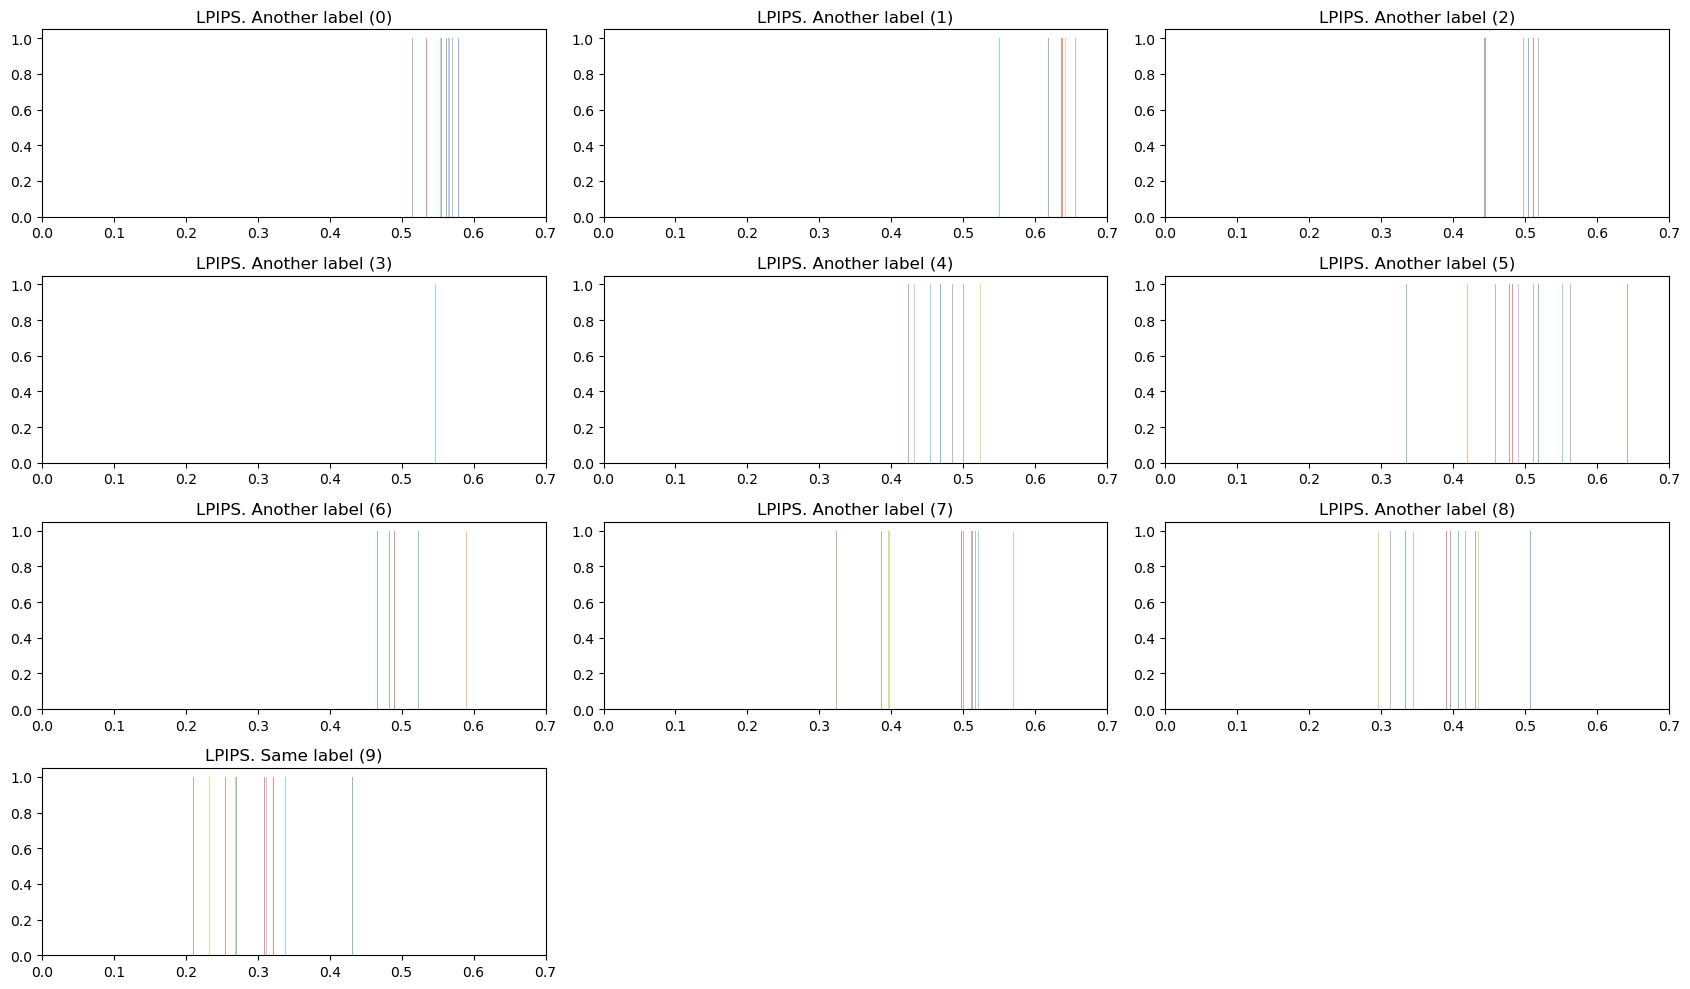

In [14]:
plt.figure(figsize=(17,10))
n_classes = 10
for label in range(n_classes):
    plt.subplot(4,3,label+1)
    plt.title(f'LPIPS. %s label (%d)' % ({True: 'Same', False: 'Another'}[label==original_label], label))
    plt.xlim((0.,0.7))
    plt.hist(np.array(distances)[np.array(labels)==label], bins=20, alpha=0.5);
plt.tight_layout();

/home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/mid/miniconda3/envs/env_310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), metho

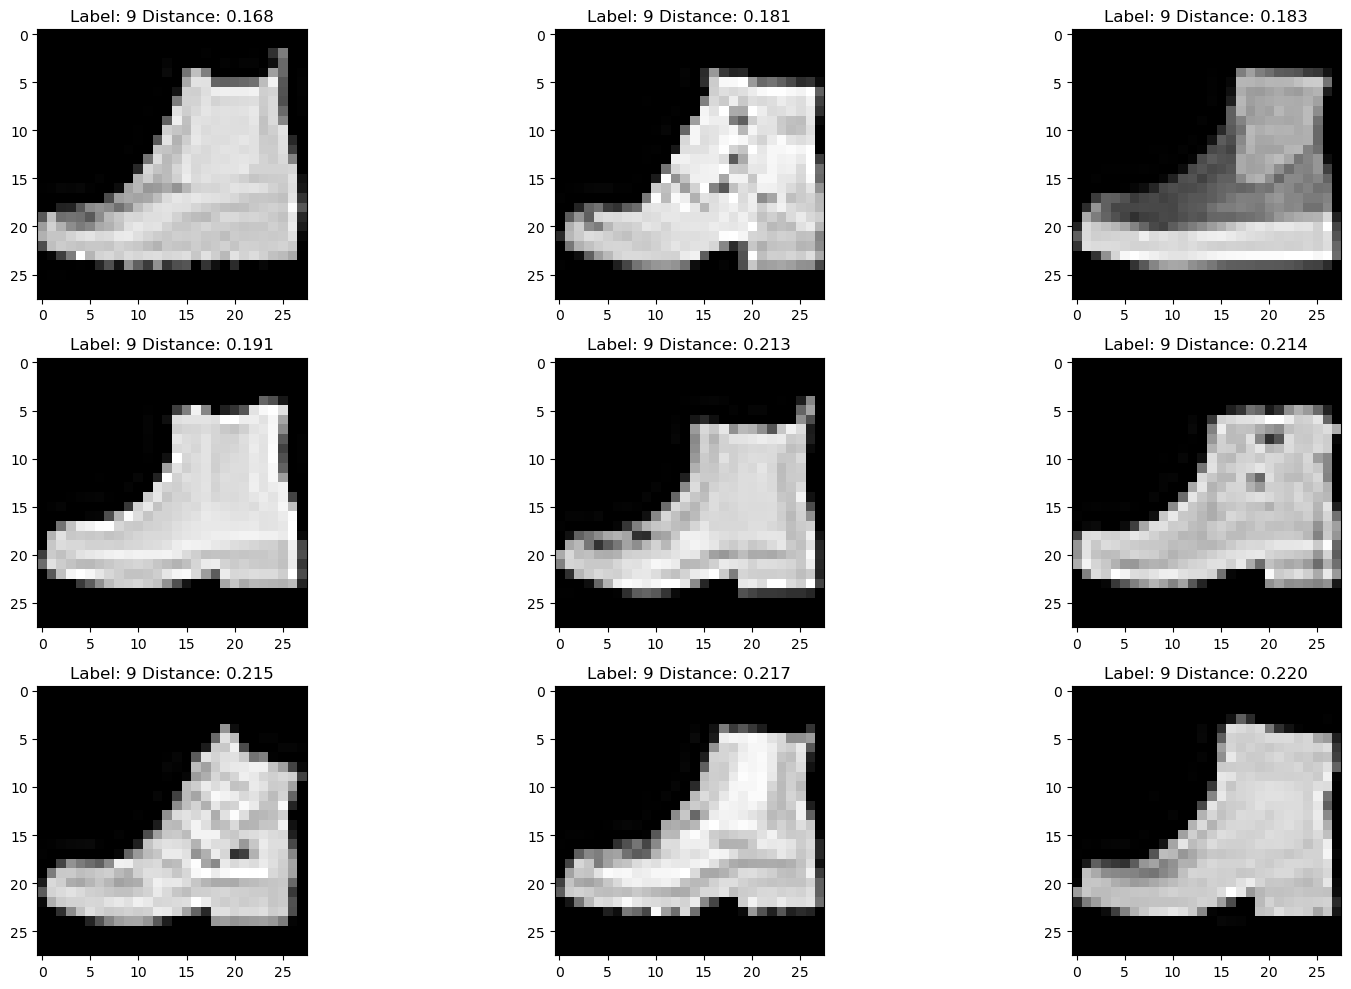

In [15]:
plt.figure(figsize=(17,10))
closest_img_cnt = 9
closest_img_indices, closest_distances, closest_labels = [
    np.array(img_indices)[np.argsort(distances)[:closest_img_cnt]], 
    np.array(distances)[np.argsort(distances)[:closest_img_cnt]], 
    np.array(labels)[np.argsort(distances)[:closest_img_cnt]]]

for ax_idx, (img_idx, distance, label) in enumerate(zip(closest_img_indices, closest_distances, closest_labels)):
    img = np.array(dataset[img_idx][0])
    plt.subplot(3,3,ax_idx+1)
    plt.title(f'Label: %d Distance: %.3f'%(label, distance))
    plt.imshow(img, cmap='gray')
plt.tight_layout();

In [16]:
## GRADED PART, DO NOT CHANGE!
q3 = (np.array(closest_labels) == original_label).mean()

In [17]:
print([min(distances), (np.array(closest_labels) == original_label).mean()])

[tensor([[[[0.1679]]]]), 1.0]
